# Training the model to predict a stock price increase in the next 10 days
https://www.analyticsvidhya.com/blog/2021/08/complete-guide-on-how-to-use-lightgbm-in-python/

In [31]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn import metrics
import pickle

import talib
from talib.abstract import *

import warnings
warnings.filterwarnings('ignore')

In [32]:
# Create the target variable

# pick a number of days divisble by 3 and add 10, since we will do a 66/33 test/train split
days_of_data = 310
data = yf.download(tickers='HOG', period=f'{days_of_data}d', progress=False)

# Code the target variable 1 for a day if the price goes above
# that day's price * 1.05 (5% increase) any day in the next 10 days.
data['target'] = 0
for d in range(0, days_of_data - 10):
    close_day_zero = data.iloc[d][3]

    # look at the next 10 days
    for i in range (d+1, d+10):
        # get closing price on that day
        close_day_i = data.iloc[i][3]
        # if closing price on that day > closing price * 1.05 on initial day,
        # then set target = 1 for the initial day
        if close_day_i > close_day_zero * 1.05:
            data.iloc[d:d+1, 6] = 1
        
# truncate so we just have the first set of rows, since we can't code the last 10
data = data.head(days_of_data - 10)

In [33]:
# check distribution of 0 vs. 1
data['target'].value_counts()

0    189
1    111
Name: target, dtype: int64

In [34]:
###############################################
# attach additional features to each row here #
###############################################

# set up running_df
running_df = pd.DataFrame([], columns=['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'])
running_df.index = running_df['Date']
running_df.drop(columns=['Date'], inplace=True)

# add columns
running_df['sma_10'] = np.NaN
running_df['sma_20'] = np.NaN
running_df['sma_30'] = np.NaN

for i in range(len(data)):
    running_df = running_df.append(data.iloc[i:i+1, 0:6])

    if len(running_df) > 10:
        running_df.iloc[-1:-2:-1, 6] = SMA(running_df.iloc[-1:-11:-1]['Close'].values, timeperiod=10)[-1]

    if len(running_df) > 20:
        running_df.iloc[-1:-2:-1, 7] = SMA(running_df.iloc[-1:-21:-1]['Close'].values, timeperiod=20)[-1]

    if len(running_df) > 30:
        running_df.iloc[-1:-2:-1, 8] = SMA(running_df.iloc[-1:-31:-1]['Close'].values, timeperiod=30)[-1]

running_df

,Open,High,Low,Close,Adj Close,Volume,sma_10,sma_20,sma_30
Date,,,,,,,,,
2020-10-29,34.080002,34.450001,33.490002,33.869999,33.336102,2998600,NaN,NaN,NaN
2020-10-30,33.549999,33.959999,32.180000,32.880001,32.361710,2958900,NaN,NaN,NaN
2020-11-02,32.689999,33.849998,32.529999,33.040001,32.519188,1958500,NaN,NaN,NaN
2020-11-03,33.689999,33.900002,33.119999,33.330002,32.804619,1568600,NaN,NaN,NaN
2020-11-04,33.130001,33.200001,32.320000,32.810001,32.292812,1894100,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2021-12-31,37.480000,37.910000,37.130001,37.689999,37.689999,822300,36.475001,37.0165,37.291667
2022-01-03,37.880001,38.139999,37.560001,37.700001,37.700001,1148800,36.604001,37.0760,37.282667
2022-01-04,38.080002,39.189999,38.080002,39.029999,39.029999,1457800,36.999001,37.1435,37.337334


In [43]:
# check column types
running_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 300 entries, 2020-10-29 to 2022-01-06
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       300 non-null    float64
 1   High       300 non-null    float64
 2   Low        300 non-null    float64
 3   Close      300 non-null    float64
 4   Adj Close  300 non-null    float64
 5   Volume     300 non-null    object 
 6   sma_10     290 non-null    float64
 7   sma_20     280 non-null    float64
 8   sma_30     270 non-null    float64
dtypes: float64(8), object(1)
memory usage: 23.4+ KB


In [45]:
# convert Volume to numeric because it changed to object for some reason
running_df['Volume'] = pd.to_numeric(running_df.Volume)

In [46]:
running_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 300 entries, 2020-10-29 to 2022-01-06
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       300 non-null    float64
 1   High       300 non-null    float64
 2   Low        300 non-null    float64
 3   Close      300 non-null    float64
 4   Adj Close  300 non-null    float64
 5   Volume     300 non-null    int64  
 6   sma_10     290 non-null    float64
 7   sma_20     280 non-null    float64
 8   sma_30     270 non-null    float64
dtypes: float64(8), int64(1)
memory usage: 23.4 KB


In [47]:
# 66/33 test/train split
train_days = int((days_of_data - 10) / 3 * 2)
test_days = int(train_days / 2)

x_train = running_df.head(train_days)
y_train = data['target'].head(train_days)

x_test = running_df.tail(test_days)
y_test = data['target'].tail(test_days)

In [48]:
# train the model
model = lgb.LGBMClassifier(learning_rate=0.5,max_depth=5,random_state=42)

model.fit(x_train,y_train,eval_set=[(x_test,y_test),(x_train,y_train)],
          verbose=20,eval_metric='logloss')

[20]	training's binary_logloss: 0.105328	valid_0's binary_logloss: 0.958168
[40]	training's binary_logloss: 0.0308243	valid_0's binary_logloss: 1.32037
[60]	training's binary_logloss: 0.00995222	valid_0's binary_logloss: 1.58095
[80]	training's binary_logloss: 0.00329617	valid_0's binary_logloss: 2.08591
[100]	training's binary_logloss: 0.00110621	valid_0's binary_logloss: 2.16839


LGBMClassifier(learning_rate=0.5, max_depth=5, random_state=42)

In [49]:
# evaluate model accuracy
print('Training accuracy {:.4f}'.format(model.score(x_train,y_train)))
print('Testing accuracy {:.4f}'.format(model.score(x_test,y_test)))

Training accuracy 1.0000
Testing accuracy 0.5900


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

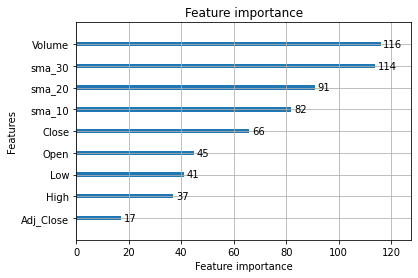

In [50]:
lgb.plot_importance(model)

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

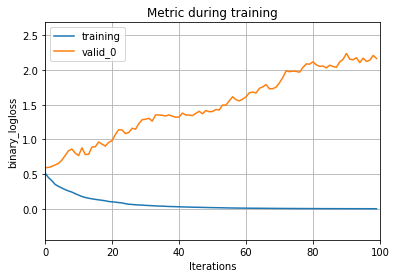

In [51]:
lgb.plot_metric(model)

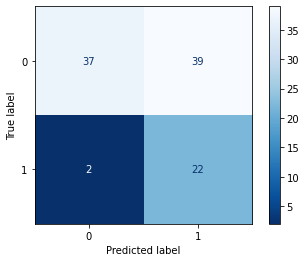

In [52]:
metrics.plot_confusion_matrix(model,x_test,y_test,cmap='Blues_r')

In [53]:
print(metrics.classification_report(y_test,model.predict(x_test)))

              precision    recall  f1-score   support

           0       0.95      0.49      0.64        76
           1       0.36      0.92      0.52        24

    accuracy                           0.59       100
   macro avg       0.65      0.70      0.58       100
weighted avg       0.81      0.59      0.61       100



In [54]:
pkl_filename = 'lgbm_model.pkl'

with open(pkl_filename, 'wb') as file:  
    pickle.dump(model, file)